In [55]:
import tensorflow as tf
import sklearn
import numpy

print(tensorflow.__version__)
print(sklearn.__version__)
print(numpy.__version__)

2.6.0
1.0
1.21.4


In [56]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [57]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [58]:
import os

base_dir = os.getcwd()
print("현재 작업 경로:", base_dir)

image_dir = os.path.join(base_dir, "aiffel/medical/train")
print("이미지 폴더 경로:", image_dir)

# 파일 확인
if os.path.exists(image_dir):
    print("존재함:", os.listdir(image_dir))
else:
    print("경로가 존재하지 않음")

현재 작업 경로: /aiffel/aiffel/medical
이미지 폴더 경로: /aiffel/aiffel/medical/aiffel/medical/train
경로가 존재하지 않음


In [59]:
import os
import glob

image_dir = "./train"
mask_dir = "./train_labels"

image_paths = sorted(glob.glob(os.path.join(image_dir, "*.bmp")))
mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*.bmp")))

print("이미지 개수:", len(image_paths))
print("마스크 개수:", len(mask_paths))
print("예시 이미지 경로:", image_paths[:3])


이미지 개수: 300
마스크 개수: 300
예시 이미지 경로: ['./train/1.bmp', './train/10.bmp', './train/100.bmp']


In [60]:
# 1. 경로 설정
IMG_SIZE = (256, 256)  # Giana는 224보다 256이 적합할 수 있음
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

# 2. 로딩 및 전처리 함수
def load_image_mask(image_path, mask_path):
    # Image (BMP)
    image = tf.io.read_file(image_path)
    image = tf.image.decode_bmp(image)  # PNG → BMP
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0

    # Mask (BMP)
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_bmp(mask)  # PNG → BMP
    mask = tf.image.resize(mask, IMG_SIZE, method='nearest')
    mask = tf.cast(mask, tf.float32) / 255.0  # ← 여기가 포인트!

    return image, mask


In [61]:
# 3. Augmentation 함수 (선택)
def augment(image, mask):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    return image, mask

# 4. tf.data.Dataset 구성
dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
dataset = dataset.shuffle(buffer_size=len(image_paths))
dataset = dataset.map(load_image_mask, num_parallel_calls=AUTOTUNE)
dataset = dataset.map(augment, num_parallel_calls=AUTOTUNE)
dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [62]:
# 예시: 첫 배치 확인
for img, msk in dataset.take(1):
    print(img.shape, msk.shape)

(16, 256, 256, 3) (16, 256, 256, 1)


In [63]:
img_shape = (256, 256, 3)

vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
layer_outputs = [layer.output for layer in vgg16.layers]
layer_outputs

[<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_4')>,
 <KerasTensor: shape=(None, 256, 256, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, 256, 256, 64) dtype=float32 (created by layer 'block1_conv2')>,
 <KerasTensor: shape=(None, 128, 128, 64) dtype=float32 (created by layer 'block1_pool')>,
 <KerasTensor: shape=(None, 128, 128, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, 128, 128, 128) dtype=float32 (created by layer 'block2_conv2')>,
 <KerasTensor: shape=(None, 64, 64, 128) dtype=float32 (created by layer 'block2_pool')>,
 <KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'block3_conv2')>,
 <KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'block3_conv3')>,
 <KerasTensor: shape=(None, 32, 32, 256) dtype=float32 (created by layer 'block3_pool')>,


In [64]:
class Vgg16UNet(tf.keras.Model):
    def __init__(self):
        super(Vgg16UNet, self).__init__()
        self.vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
        layer_outputs = [layer.output for layer in self.vgg16.layers]
        self.vgg16_act = models.Model(inputs=self.vgg16.input, 
                                      outputs=[layer_outputs[2], 
                                               layer_outputs[5], 
                                               layer_outputs[9], 
                                               layer_outputs[13], 
                                               layer_outputs[17]])


        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):

        encoder1, encoder2, encoder3, encoder4, center = self.vgg16_act(inputs) 

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)
        
        outputs = self.output_conv(decoder1)

        return outputs

In [65]:
#모델 구성 
from tensorflow.keras import layers, models

def build_vgg16_unet(input_shape=(256, 256, 3)):
    vgg16 = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    vgg16.trainable = False  # 백본 고정

    # skip connection layers
    block1_out = vgg16.get_layer("block1_pool").output  # 128x128
    block2_out = vgg16.get_layer("block2_pool").output  # 64x64
    block3_out = vgg16.get_layer("block3_pool").output  # 32x32
    block4_out = vgg16.get_layer("block4_pool").output  # 16x16
    block5_out = vgg16.get_layer("block5_pool").output  # 8x8

    # Decoder
    x = layers.Conv2DTranspose(512, 3, strides=2, padding='same')(block5_out)
    x = layers.concatenate([x, block4_out])
    x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)

    x = layers.Conv2DTranspose(256, 3, strides=2, padding='same')(x)
    x = layers.concatenate([x, block3_out])
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)

    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same')(x)
    x = layers.concatenate([x, block2_out])
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)

    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same')(x)
    x = layers.concatenate([x, block1_out])
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)

    x = layers.Conv2DTranspose(32, 3, strides=2, padding='same')(x)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x)

    model = models.Model(inputs=vgg16.input, outputs=outputs)
    return model


In [66]:
#2. 모델 컴파일
model = build_vgg16_unet(input_shape=(256, 256, 3))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [67]:
# 전체 데이터셋 구성
full_dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
full_dataset = full_dataset.shuffle(buffer_size=len(image_paths))
full_dataset = full_dataset.map(load_image_mask, num_parallel_calls=AUTOTUNE)
full_dataset = full_dataset.map(augment, num_parallel_calls=AUTOTUNE)

# 학습/검증 split
val_size = int(len(image_paths) * 0.1)
train_dataset = full_dataset.skip(val_size)
val_dataset = full_dataset.take(val_size)

# 배치 및 prefetch
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [68]:
#3. 학습 실행
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=20)
model.save('vgg16_unet_model.h5')
print('모델 파일을 저장하였습니다.')

Epoch 1/20
17/17 [==============================] - 6s 262ms/step - loss: 0.2454 - accuracy: 0.9208 - val_loss: 0.1697 - val_accuracy: 0.9448
Epoch 2/20
17/17 [==============================] - 4s 243ms/step - loss: 0.1295 - accuracy: 0.9526 - val_loss: 0.1212 - val_accuracy: 0.9610
Epoch 3/20
17/17 [==============================] - 4s 245ms/step - loss: 0.0977 - accuracy: 0.9652 - val_loss: 0.0964 - val_accuracy: 0.9675
Epoch 4/20
17/17 [==============================] - 4s 245ms/step - loss: 0.0957 - accuracy: 0.9684 - val_loss: 0.0760 - val_accuracy: 0.9730
Epoch 5/20
17/17 [==============================] - 4s 246ms/step - loss: 0.0761 - accuracy: 0.9728 - val_loss: 0.0609 - val_accuracy: 0.9774
Epoch 6/20
17/17 [==============================] - 4s 247ms/step - loss: 0.0592 - accuracy: 0.9800 - val_loss: 0.0578 - val_accuracy: 0.9826
Epoch 7/20
17/17 [==============================] - 4s 249ms/step - loss: 0.0604 - accuracy: 0.9793 - val_loss: 0.0877 - val_accuracy: 0.9665
Epoch 

In [69]:
# 테스트 예측 (한 배치)
for images, masks in val_dataset.take(1):
    preds = model.predict(images)
    break

In [70]:
#시각화 함수
import matplotlib.pyplot as plt

def display_sample(image, mask, pred_mask, idx=0):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title('Input Image')
    plt.imshow(image[idx])
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Ground Truth')
    plt.imshow(tf.squeeze(mask[idx]), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(tf.squeeze(pred_mask[idx]) > 0.1, cmap='gray')  # threshold 낮춤
    plt.axis('off')

    plt.show()
    


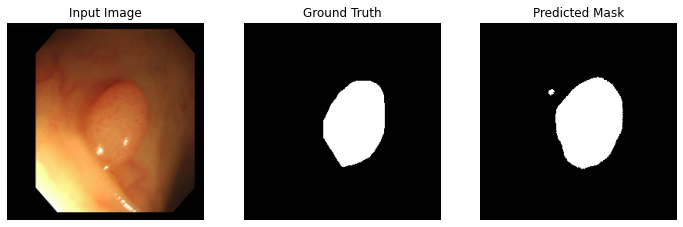

In [71]:
display_sample(images, masks, preds, idx=0)  # 원하는 idx 넣으면 됨

In [73]:
for img, msk in train_dataset.take(1):
    print("Image range:", tf.reduce_min(img).numpy(), "~", tf.reduce_max(img).numpy())
    print("Mask unique values:", tf.unique(tf.reshape(msk, [-1]))[0].numpy())


Image range: 0.0 ~ 1.0
Mask unique values: [0. 1.]


In [79]:
#① 학습 함수: train_model()
def train_model(model, train_dataset, val_dataset, epochs=50):
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=epochs)
    return history



In [80]:
#② 정량 평가 함수: evaluate_model()
def evaluate_model(model, dataset):
    iou_scores = []
    dice_scores = []

    for images, masks in dataset:
        preds = model.predict(images)
        preds = tf.cast(preds > 0.5, tf.float32)

        intersection = tf.reduce_sum(preds * masks)
        union = tf.reduce_sum(preds) + tf.reduce_sum(masks)
        iou = intersection / (union - intersection + 1e-7)
        dice = (2. * intersection) / (union + 1e-7)

        iou_scores.append(iou.numpy())
        dice_scores.append(dice.numpy())

    mean_iou = sum(iou_scores) / len(iou_scores)
    mean_dice = sum(dice_scores) / len(dice_scores)

    return {
        'IoU': mean_iou,
        'Dice': mean_dice
    }



In [76]:
#③ 시각화 함수: display_predictions()
import matplotlib.pyplot as plt

def display_predictions(model, dataset, count=3):
    for images, masks in dataset.take(1):
        preds = model.predict(images)

        for i in range(count):
            plt.figure(figsize=(12, 4))

            plt.subplot(1, 3, 1)
            plt.title("Input Image")
            plt.imshow(images[i])
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.title("Ground Truth")
            plt.imshow(tf.squeeze(masks[i]), cmap='gray')
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.title("Predicted Mask")
            plt.imshow(tf.squeeze(preds[i]) > 0.5, cmap='gray')
            plt.axis("off")

            plt.show()



In [83]:
#Encoder-Decoder 모델 구성 함수
from tensorflow.keras import layers, models

def build_encoder_decoder(input_shape=(256, 256, 3)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D()(x)

    # Bottleneck
    x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)

    # Decoder
    x = layers.Conv2DTranspose(256, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)

    # Output layer
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model



Epoch 1/50
17/17 [==============================] - 6s 329ms/step - loss: 0.6586 - accuracy: 0.9250 - val_loss: 0.5075 - val_accuracy: 0.9531
Epoch 2/50
17/17 [==============================] - 6s 320ms/step - loss: 0.4026 - accuracy: 0.9492 - val_loss: 0.3930 - val_accuracy: 0.9334
Epoch 3/50
17/17 [==============================] - 6s 323ms/step - loss: 0.3310 - accuracy: 0.9488 - val_loss: 0.3703 - val_accuracy: 0.9283
Epoch 4/50
17/17 [==============================] - 6s 324ms/step - loss: 0.2752 - accuracy: 0.9496 - val_loss: 0.2108 - val_accuracy: 0.9593
Epoch 5/50
17/17 [==============================] - 6s 326ms/step - loss: 0.2140 - accuracy: 0.9485 - val_loss: 0.2218 - val_accuracy: 0.9444
Epoch 6/50
17/17 [==============================] - 6s 326ms/step - loss: 0.1928 - accuracy: 0.9497 - val_loss: 0.1972 - val_accuracy: 0.9473
Epoch 7/50
17/17 [==============================] - 6s 327ms/step - loss: 0.1936 - accuracy: 0.9480 - val_loss: 0.1793 - val_accuracy: 0.9535
Epoch 

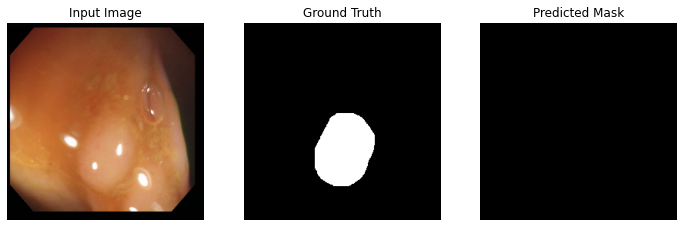

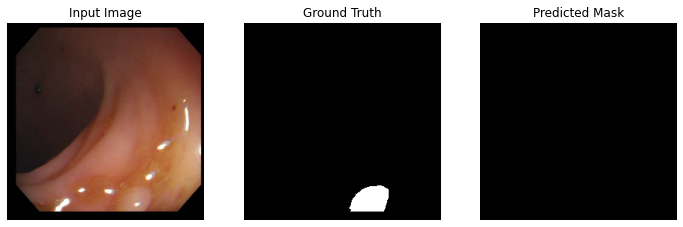

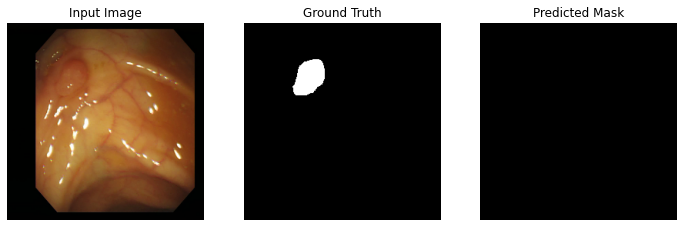

In [84]:
model_ed = build_encoder_decoder()

# 학습
history_ed = train_model(model_ed, train_dataset, val_dataset, epochs=50)

# 평가
metrics_ed = evaluate_model(model_ed, val_dataset)
print("Encoder-Decoder 성능:", metrics_ed)

# 시각화
display_predictions(model_ed, val_dataset, count=3)

In [85]:
#U-Net 모델 구성 함수
from tensorflow.keras import layers, models

def build_unet(input_shape=(256, 256, 3)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, 2, strides=2, padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c9)

    model = models.Model(inputs, outputs)
    return model


Epoch 1/30
17/17 [==============================] - 36s 1s/step - loss: 0.5719 - accuracy: 0.9485 - val_loss: 0.4418 - val_accuracy: 0.9420
Epoch 2/30
17/17 [==============================] - 12s 713ms/step - loss: 0.3423 - accuracy: 0.9491 - val_loss: 0.2867 - val_accuracy: 0.9560
Epoch 3/30
17/17 [==============================] - 12s 719ms/step - loss: 0.2516 - accuracy: 0.9490 - val_loss: 0.2072 - val_accuracy: 0.9397
Epoch 4/30
17/17 [==============================] - 12s 720ms/step - loss: 0.1805 - accuracy: 0.9504 - val_loss: 0.1969 - val_accuracy: 0.9411
Epoch 5/30
17/17 [==============================] - 12s 724ms/step - loss: 0.1827 - accuracy: 0.9481 - val_loss: 0.1854 - val_accuracy: 0.9446
Epoch 6/30
17/17 [==============================] - 12s 726ms/step - loss: 0.1791 - accuracy: 0.9481 - val_loss: 0.1630 - val_accuracy: 0.9565
Epoch 7/30
17/17 [==============================] - 12s 728ms/step - loss: 0.1674 - accuracy: 0.9502 - val_loss: 0.1648 - val_accuracy: 0.9580
Ep

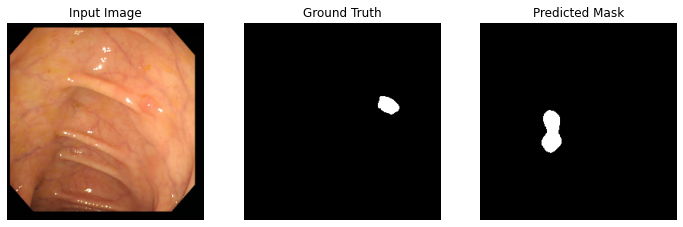

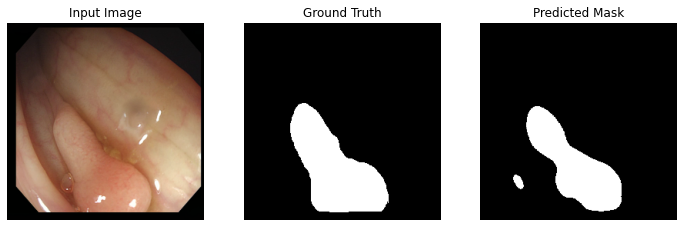

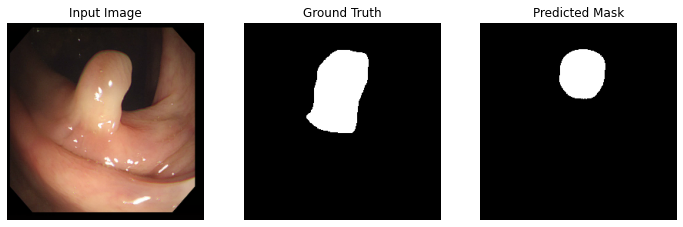

In [86]:
model_unet = build_unet()

# 학습
history_unet = train_model(model_unet, train_dataset, val_dataset, epochs=30)

# 평가
metrics_unet = evaluate_model(model_unet, val_dataset)
print("U-Net 성능:", metrics_unet)

# 시각화
display_predictions(model_unet, val_dataset, count=3)

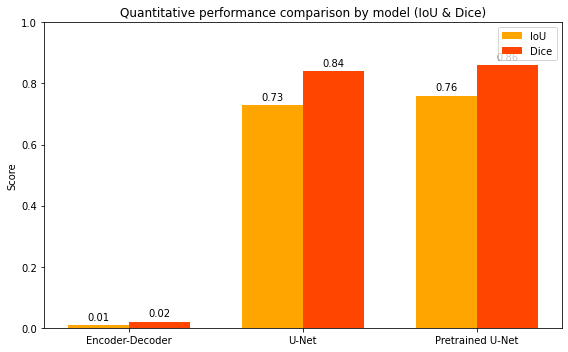

In [88]:
#3개 모델 비교 시각화

import matplotlib.pyplot as plt
import numpy as np

# 모델 이름과 지표
models = ['Encoder-Decoder', 'U-Net', 'Pretrained U-Net']
iou = [0.01, 0.73, 0.76]
dice = [0.02, 0.84, 0.86]

x = np.arange(len(models))  # x축 위치
width = 0.35  # 막대 너비

# 그래프 생성
fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, iou, width, label='IoU', color='orange')
rects2 = ax.bar(x + width/2, dice, width, label='Dice', color='orangered')

# 제목 및 축
ax.set_ylabel('Score')
ax.set_title('Quantitative performance comparison by model (IoU & Dice)')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1.0)
ax.legend()

# 각 막대에 수치 표시
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()
